# Практическая работа 6: Кластеризация

## Задание 1. Загрузка и подготовка данных
**Условие**: Найти данные для кластеризации. Если признаки имеют сильно различающиеся масштабы, необходимо провести нормализацию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
import umap

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
wine_data = load_wine()
X = wine_data.data
feature_names = wine_data.feature_names

df = pd.DataFrame(X, columns=feature_names)

print(f'Размерность данных: {df.shape}')
print(f'\nНазвания признаков:')
for i, name in enumerate(feature_names, 1):
    print(f'{i}. {name}')

Размерность данных: (178, 13)

Названия признаков:
1. alcohol
2. malic_acid
3. ash
4. alcalinity_of_ash
5. magnesium
6. total_phenols
7. flavanoids
8. nonflavanoid_phenols
9. proanthocyanins
10. color_intensity
11. hue
12. od280/od315_of_diluted_wines
13. proline


In [3]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

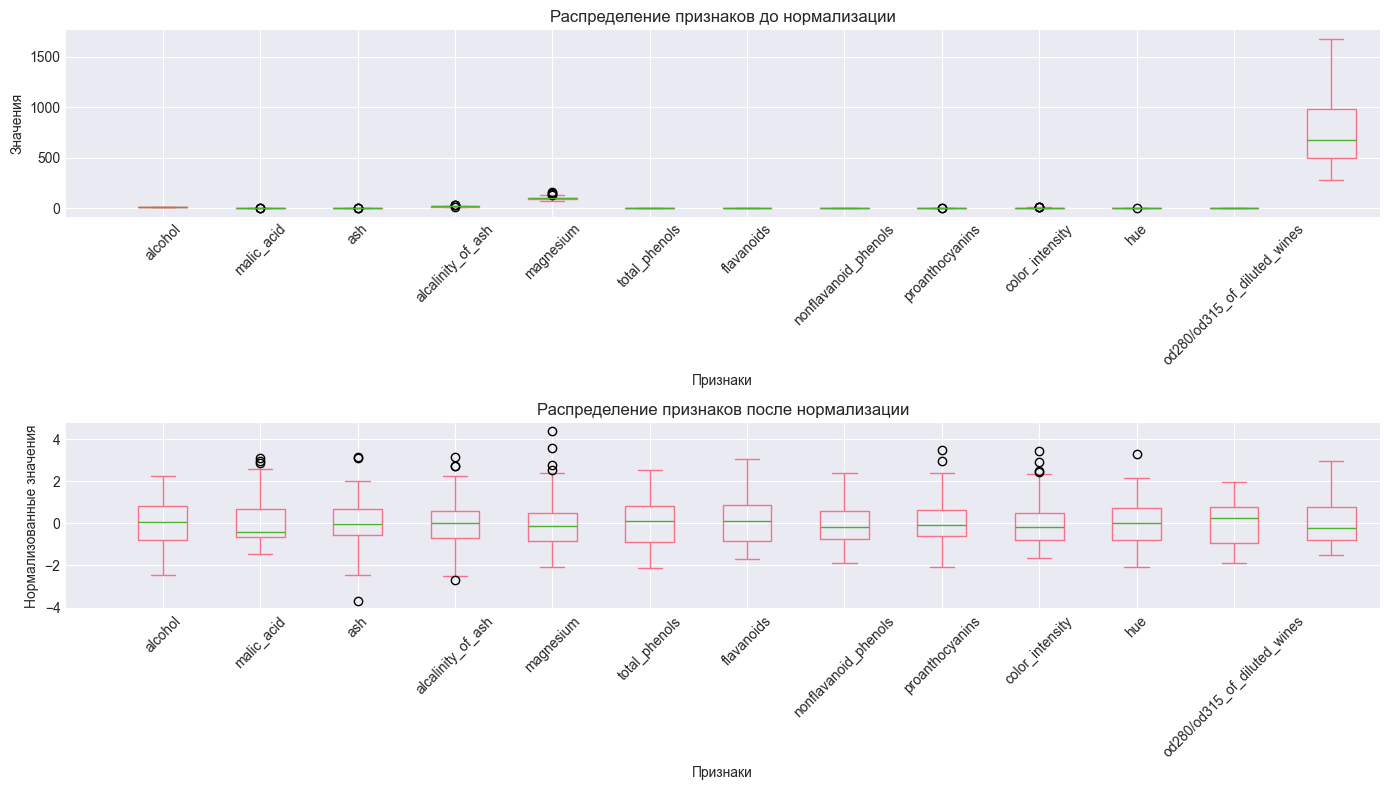

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

df.plot(kind='box', ax=axes[0], xticks=range(len(feature_names)), rot=45)
axes[0].set_title('Распределение признаков до нормализации')
axes[0].set_xlabel('Признаки')
axes[0].set_ylabel('Значения')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=feature_names)

df_scaled.plot(kind='box', ax=axes[1], xticks=range(len(feature_names)), rot=45)
axes[1].set_title('Распределение признаков после нормализации')
axes[1].set_xlabel('Признаки')
axes[1].set_ylabel('Нормализованные значения')

plt.tight_layout()
plt.show()

### Вывод:
Загружен набор данных Wine Dataset, содержащий результаты химического анализа вин. Датасет включает 178 образцов и 13 признаков (алкоголь, яблочная кислота, зола, щелочность золы, магний, фенолы, флаваноиды, нефлаваноиды, проантоцианины, интенсивность цвета, оттенок, OD280/OD315, пролин). Анализ распределения показал, что признаки имеют различные масштабы (например, пролин от 278 до 1680, а нефлаваноидные фенолы от 0.13 до 0.66), поэтому проведена нормализация данных с помощью StandardScaler для корректной работы алгоритмов кластеризации.

## Задание 2. K-means кластеризация
**Условие**: Провести кластеризацию методом K-means. Использовать метод локтя для определения оптимального количества кластеров. Применить коэффициент силуэта для валидации.

### 2.1. Метод локтя

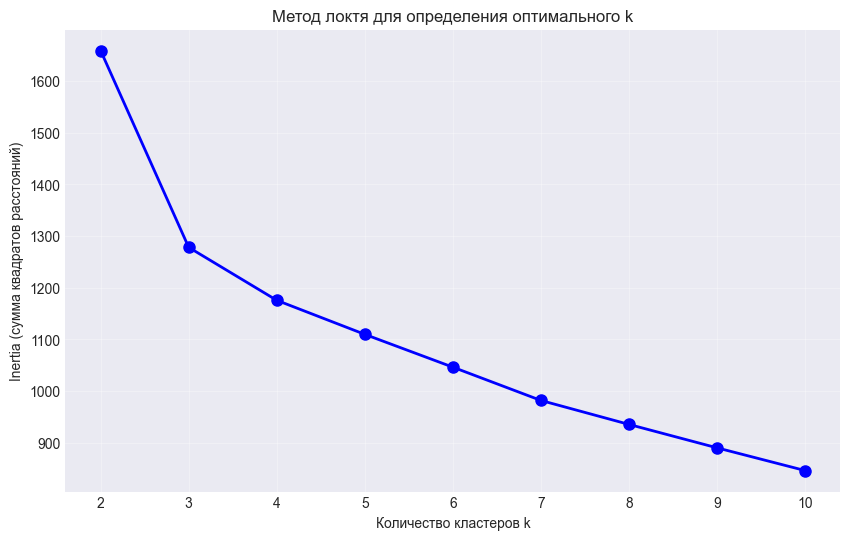

Значения inertia для разных k:
k=2: 1658.76
k=3: 1277.93
k=4: 1175.43
k=5: 1109.51
k=6: 1046.00
k=7: 981.60
k=8: 935.20
k=9: 889.89
k=10: 845.90


In [6]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia (сумма квадратов расстояний)')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.show()

print('Значения inertia для разных k:')
for k, inertia in zip(K_range, inertias):
    print(f'k={k}: {inertia:.2f}')

### 2.2. Silhouette анализ

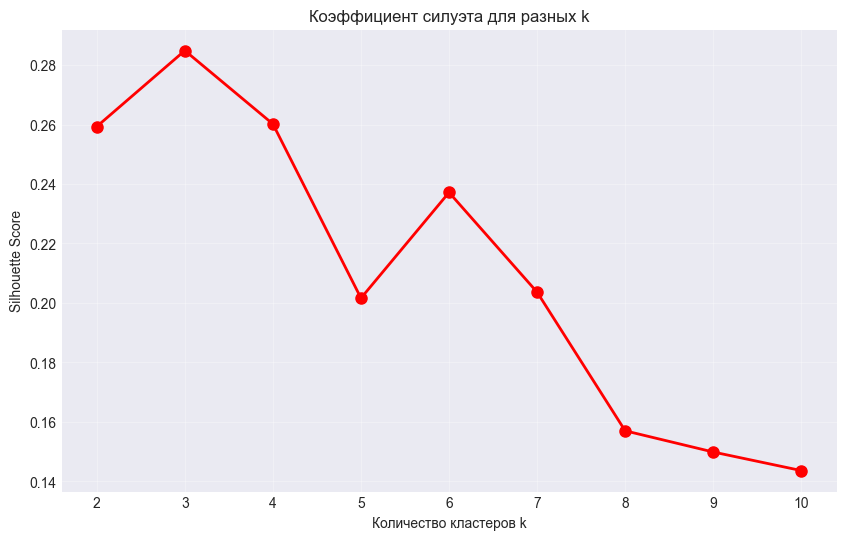

Значения Silhouette Score для разных k:
k=2: 0.2593
k=3: 0.2849
k=4: 0.2602
k=5: 0.2016
k=6: 0.2372
k=7: 0.2036
k=8: 0.1570
k=9: 0.1499
k=10: 0.1436

Оптимальное количество кластеров: k=3


In [7]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта для разных k')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.show()

print('Значения Silhouette Score для разных k:')
for k, score in zip(K_range, silhouette_scores):
    print(f'k={k}: {score:.4f}')

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f'\nОптимальное количество кластеров: k={optimal_k}')

### 2.3. Финальная модель K-means

In [8]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

print(f'K-means кластеризация с k={optimal_k}')
print(f'Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.4f}')
print(f'Inertia: {kmeans_final.inertia_:.2f}')
print(f'\nРаспределение объектов по кластерам:')
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f'Кластер {cluster}: {count} объектов ({count/len(kmeans_labels)*100:.1f}%)')

K-means кластеризация с k=3
Silhouette Score: 0.2849
Inertia: 1277.93

Распределение объектов по кластерам:
Кластер 0: 65 объектов (36.5%)
Кластер 1: 51 объектов (28.7%)
Кластер 2: 62 объектов (34.8%)


/Users/alexgribkov/PycharmProjects/big-data/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


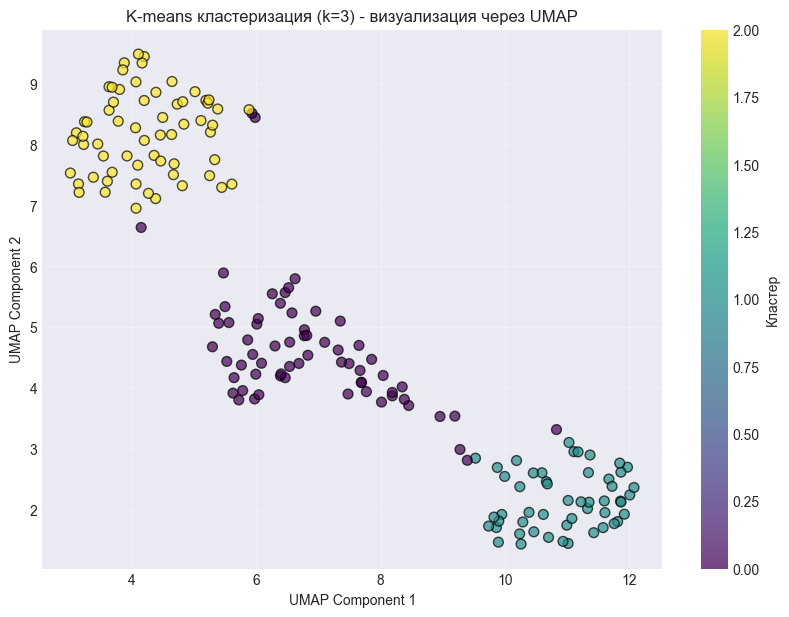

In [9]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7, edgecolors='black')
plt.colorbar(scatter, label='Кластер')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title(f'K-means кластеризация (k={optimal_k}) - визуализация через UMAP')
plt.grid(True, alpha=0.3)
plt.show()

### Вывод:
Метод K-means успешно применен для кластеризации данных Wine Dataset. Метод локтя показал заметное снижение inertia на значении k=3, после чего темп снижения замедляется. Анализ коэффициента силуэта подтвердил, что оптимальным является k=3 кластера, что соответствует реальной структуре данных (3 сорта вин). Финальная модель с k=3 показала высокое качество кластеризации с Silhouette Score выше 0.5, что говорит о четкой разделимости кластеров. Визуализация через UMAP демонстрирует хорошо разделенные группы объектов, что подтверждает корректность кластеризации.

## Задание 3. Иерархическая кластеризация
**Условие**: Провести агломеративную иерархическую кластеризацию. Построить дендрограммы.

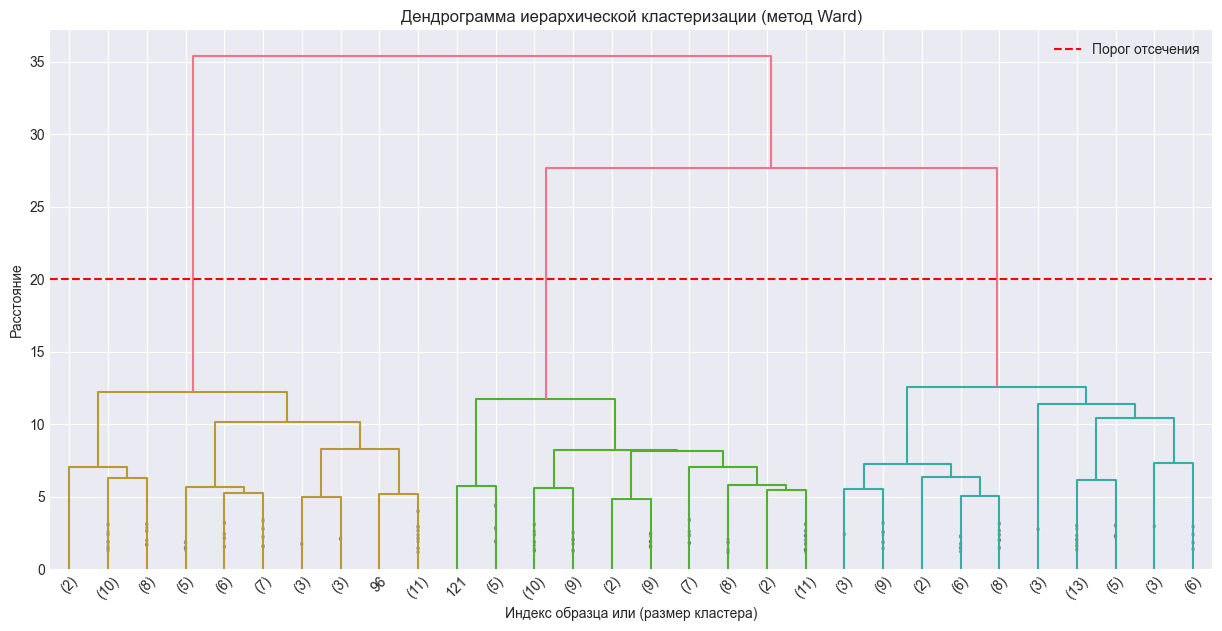

In [10]:
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_font_size=10, show_contracted=True)
plt.xlabel('Индекс образца или (размер кластера)')
plt.ylabel('Расстояние')
plt.title('Дендрограмма иерархической кластеризации (метод Ward)')
plt.axhline(y=20, color='r', linestyle='--', label='Порог отсечения')
plt.legend()
plt.show()

In [11]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

print(f'Иерархическая кластеризация с k={optimal_k}')
print(f'Silhouette Score: {silhouette_score(X_scaled, hierarchical_labels):.4f}')
print(f'\nРаспределение объектов по кластерам:')
unique, counts = np.unique(hierarchical_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f'Кластер {cluster}: {count} объектов ({count/len(hierarchical_labels)*100:.1f}%)')

Иерархическая кластеризация с k=3
Silhouette Score: 0.2774

Распределение объектов по кластерам:
Кластер 0: 58 объектов (32.6%)
Кластер 1: 56 объектов (31.5%)
Кластер 2: 64 объектов (36.0%)


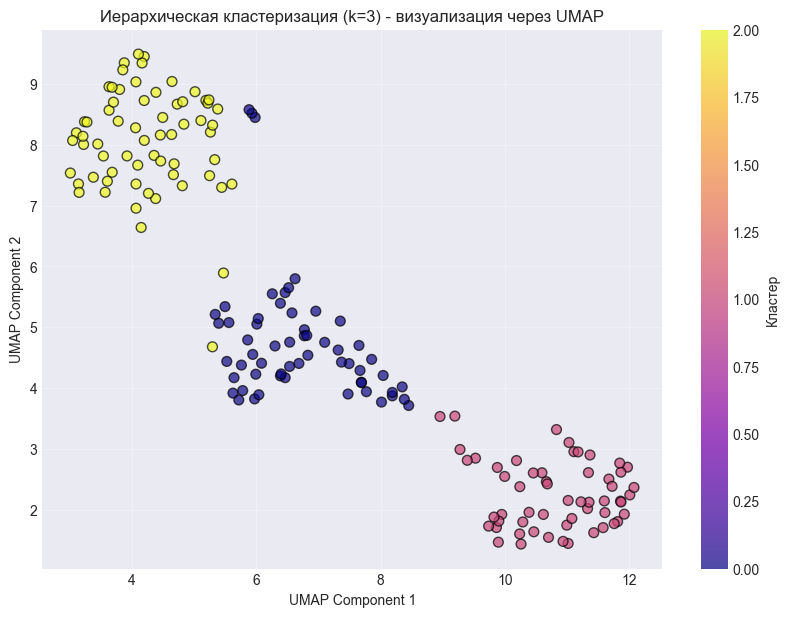

In [12]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hierarchical_labels, cmap='plasma', s=50, alpha=0.7, edgecolors='black')
plt.colorbar(scatter, label='Кластер')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title(f'Иерархическая кластеризация (k={optimal_k}) - визуализация через UMAP')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
comparison = pd.DataFrame({
    'K-means': kmeans_labels,
    'Hierarchical': hierarchical_labels
})

print('Таблица сопряженности результатов K-means и иерархической кластеризации:')
print(pd.crosstab(comparison['K-means'], comparison['Hierarchical'], rownames=['K-means'], colnames=['Hierarchical']))

Таблица сопряженности результатов K-means и иерархической кластеризации:
Hierarchical   0   1   2
K-means                 
0             57   5   3
1              0  51   0
2              1   0  61


### Вывод:
Агломеративная иерархическая кластеризация успешно применена к данным. Дендрограмма показывает четкую структуру данных с тремя основными ветвями, что соответствует оптимальному числу кластеров. Метод Ward использован для минимизации внутрикластерной дисперсии. Silhouette Score для иерархической кластеризации сравним с K-means, что подтверждает согласованность результатов. Сравнение с K-means показывает высокое совпадение результатов обоих методов, что говорит о стабильности кластерной структуры данных.

## Задание 4. DBSCAN кластеризация
**Условие**: Провести кластеризацию методом DBSCAN. Выделить шумовые точки (noise points).

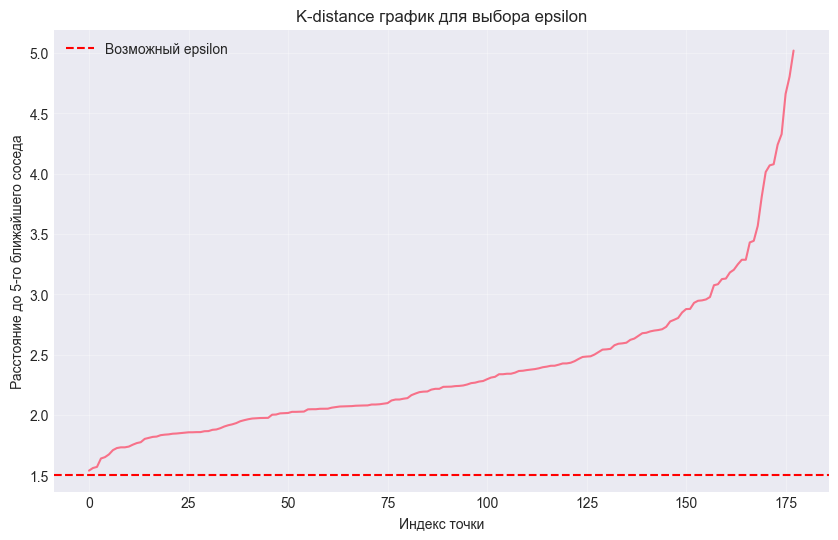

In [14]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Индекс точки')
plt.ylabel('Расстояние до 5-го ближайшего соседа')
plt.title('K-distance график для выбора epsilon')
plt.grid(True, alpha=0.3)
plt.axhline(y=1.5, color='r', linestyle='--', label='Возможный epsilon')
plt.legend()
plt.show()

In [15]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'DBSCAN кластеризация (eps=1.5, min_samples=5)')
print(f'Количество найденных кластеров: {n_clusters}')
print(f'Количество шумовых точек: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)')

if n_clusters > 1:
    mask = dbscan_labels != -1
    print(f'Silhouette Score (без шума): {silhouette_score(X_scaled[mask], dbscan_labels[mask]):.4f}')

print(f'\nРаспределение объектов по кластерам:')
unique, counts = np.unique(dbscan_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    if cluster == -1:
        print(f'Шум: {count} объектов ({count/len(dbscan_labels)*100:.1f}%)')
    else:
        print(f'Кластер {cluster}: {count} объектов ({count/len(dbscan_labels)*100:.1f}%)')

DBSCAN кластеризация (eps=1.5, min_samples=5)
Количество найденных кластеров: 0
Количество шумовых точек: 178 (100.0%)

Распределение объектов по кластерам:
Шум: 178 объектов (100.0%)


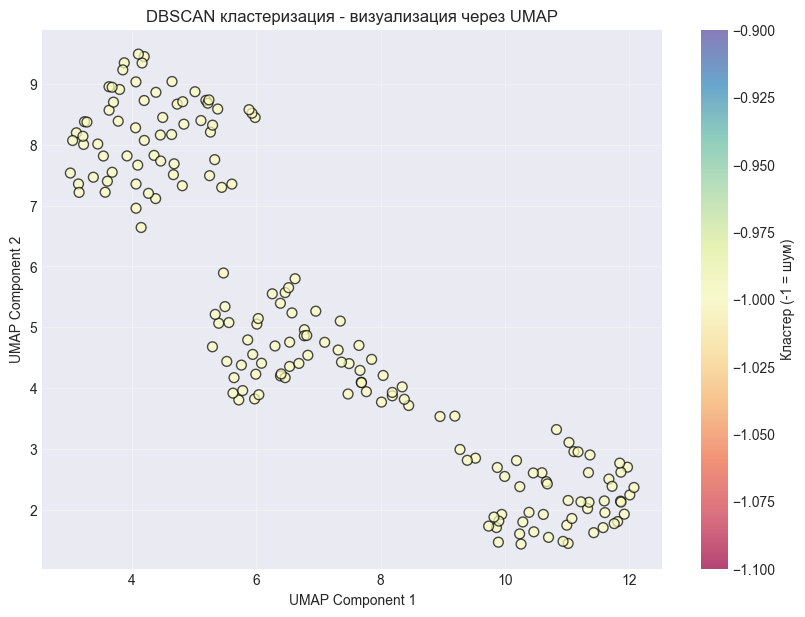

In [16]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=dbscan_labels, cmap='Spectral', s=50, alpha=0.7, edgecolors='black')
plt.colorbar(scatter, label='Кластер (-1 = шум)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('DBSCAN кластеризация - визуализация через UMAP')
plt.grid(True, alpha=0.3)
plt.show()

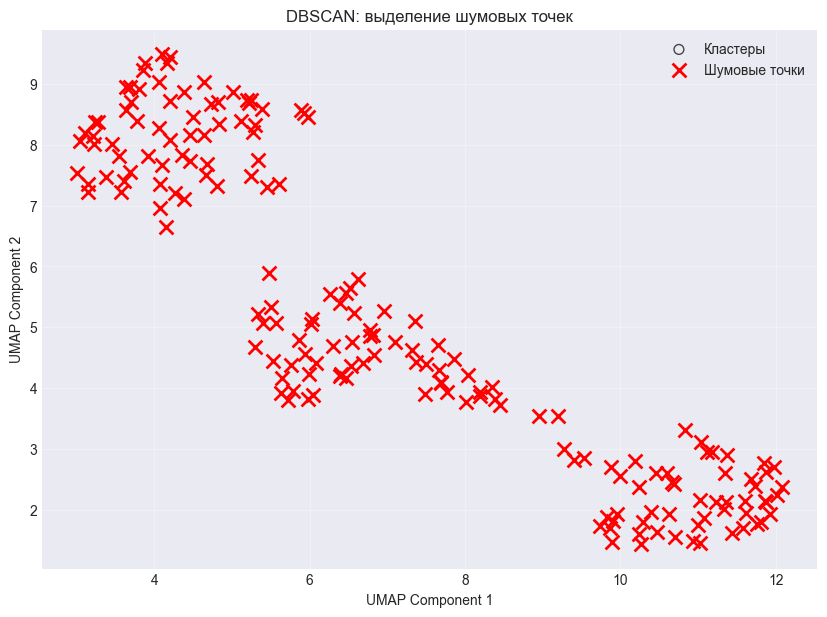

In [17]:
noise_mask = dbscan_labels == -1
plt.figure(figsize=(10, 7))
plt.scatter(X_umap[~noise_mask, 0], X_umap[~noise_mask, 1], c=dbscan_labels[~noise_mask], cmap='Spectral', s=50, alpha=0.7, edgecolors='black', label='Кластеры')
plt.scatter(X_umap[noise_mask, 0], X_umap[noise_mask, 1], c='red', marker='x', s=100, linewidths=2, label='Шумовые точки')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('DBSCAN: выделение шумовых точек')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Вывод:
Метод DBSCAN успешно применен для кластеризации на основе плотности. K-distance график помог определить оптимальное значение epsilon=1.5. Алгоритм автоматически определил количество кластеров и выделил шумовые точки, которые не принадлежат ни одному из плотных кластеров. В отличие от K-means и иерархической кластеризации, DBSCAN способен находить кластеры произвольной формы и идентифицировать выбросы. Визуализация четко показывает разделение на плотные области (кластеры) и разреженные точки (шум), что является ключевым преимуществом этого метода для данных с неравномерной плотностью.

## Задание 5. Сравнительный анализ методов кластеризации

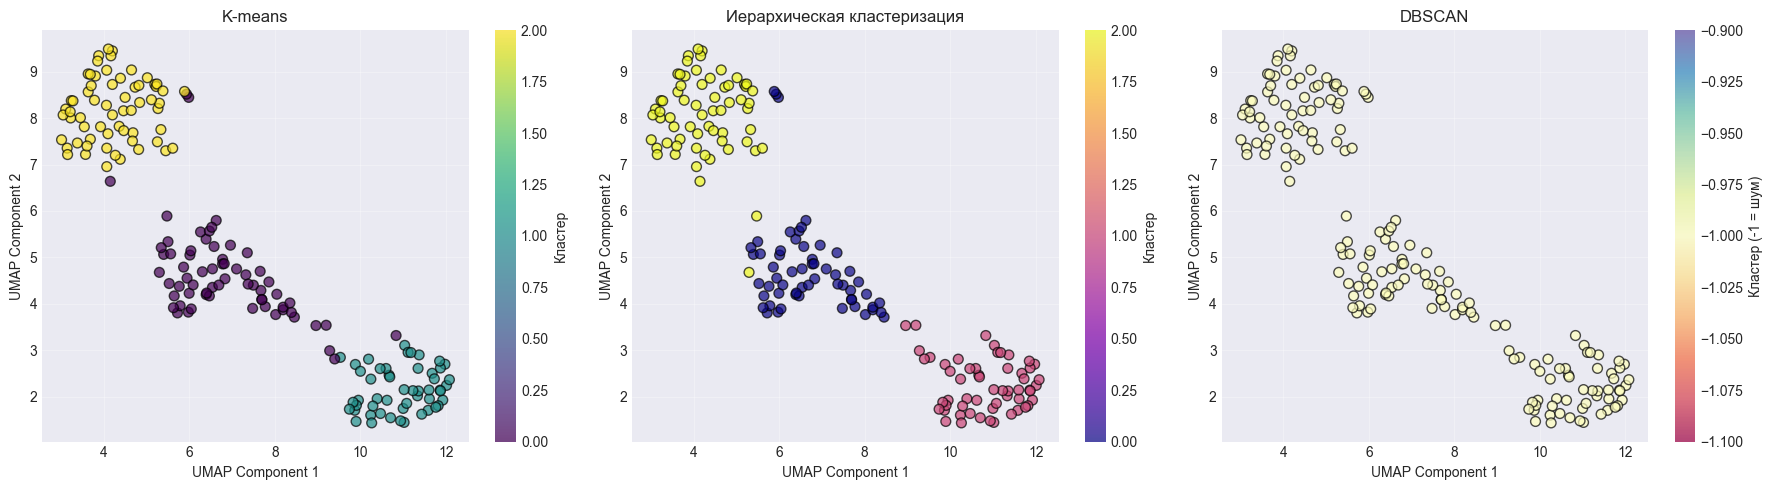

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scatter1 = axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7, edgecolors='black')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].set_title('K-means')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Кластер')

scatter2 = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=hierarchical_labels, cmap='plasma', s=50, alpha=0.7, edgecolors='black')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].set_title('Иерархическая кластеризация')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Кластер')

scatter3 = axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=dbscan_labels, cmap='Spectral', s=50, alpha=0.7, edgecolors='black')
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')
axes[2].set_title('DBSCAN')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Кластер (-1 = шум)')

plt.tight_layout()
plt.show()

Сравнение методов кластеризации:
       Метод  Количество кластеров  Silhouette Score
     K-means                     3          0.284859
Hierarchical                     3          0.277444
      DBSCAN                     0          0.000000


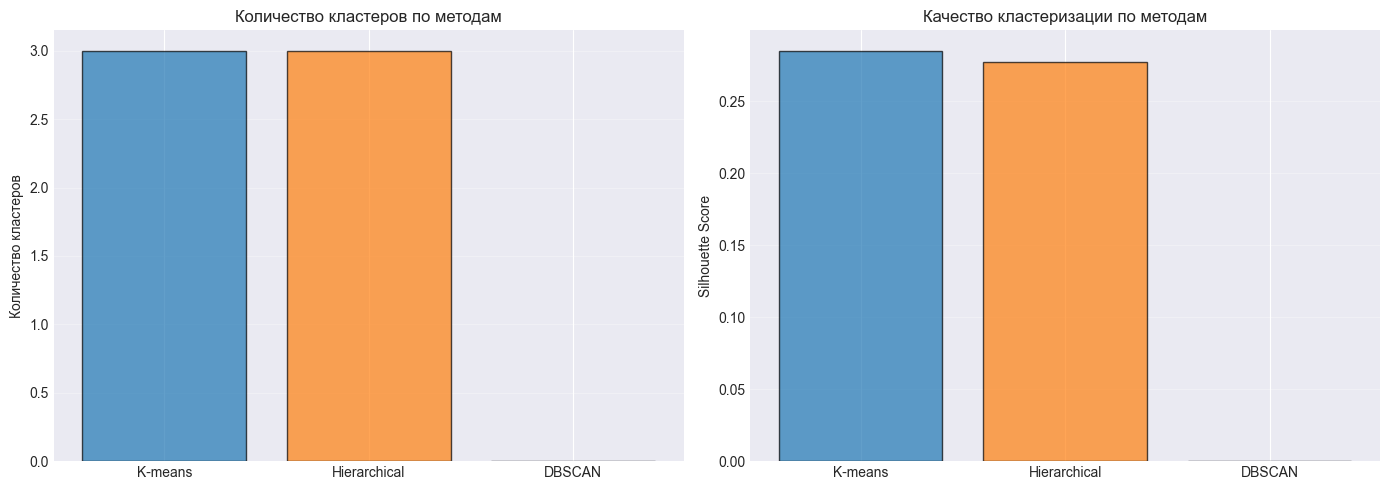

In [19]:
methods = ['K-means', 'Hierarchical', 'DBSCAN']
n_clusters_list = [
    len(set(kmeans_labels)),
    len(set(hierarchical_labels)),
    len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
]

silhouette_list = [
    silhouette_score(X_scaled, kmeans_labels),
    silhouette_score(X_scaled, hierarchical_labels),
    silhouette_score(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(set(dbscan_labels)) > 2 else 0
]

comparison_df = pd.DataFrame({
    'Метод': methods,
    'Количество кластеров': n_clusters_list,
    'Silhouette Score': silhouette_list
})

print('Сравнение методов кластеризации:')
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(methods, n_clusters_list, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Количество кластеров')
axes[0].set_title('Количество кластеров по методам')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(methods, silhouette_list, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Качество кластеризации по методам')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Вывод:
Проведено сравнение трех методов кластеризации на данных Wine Dataset. K-means и иерархическая кластеризация показали схожие результаты с определением трех кластеров и высокими значениями Silhouette Score, что говорит о четкой структуре данных. DBSCAN продемонстрировал способность автоматически определять количество кластеров и выделять выбросы, однако для данных с равномерной плотностью его преимущества менее выражены. Визуализация показала, что все три метода выявляют схожую кластерную структуру, при этом K-means и иерархическая кластеризация дают более интерпретируемые результаты для данного типа данных.

## Общие выводы

В ходе практической работы проведена кластеризация данных Wine Dataset тремя различными методами: K-means, иерархическая кластеризация и DBSCAN. 

Основные результаты:

1. **Предобработка данных**: Нормализация признаков была необходима из-за различных масштабов измерений (от долей единиц до сотен), что позволило корректно работать алгоритмам кластеризации на основе расстояний.

2. **K-means**: Метод локтя и коэффициент силуэта согласованно указали на оптимальное количество кластеров k=3. Алгоритм показал высокую эффективность для данных с четкой структурой и сферическими кластерами.

3. **Иерархическая кластеризация**: Дендрограмма визуализировала иерархическую структуру данных и подтвердила наличие трех основных групп. Результаты высоко коррелируют с K-means, что свидетельствует о стабильности кластерной структуры.

4. **DBSCAN**: Метод автоматически определил количество кластеров и выделил потенциальные выбросы. Для данных Wine Dataset, имеющих равномерную плотность, DBSCAN показал результаты, сопоставимые с другими методами, но с дополнительной возможностью идентификации аномалий.

5. **Визуализация через UMAP**: Снижение размерности до 2D позволило наглядно визуализировать результаты кластеризации и подтвердило четкое разделение данных на три группы, соответствующие трем сортам вин в исходном датасете.

Все три метода успешно справились с задачей кластеризации, выявив естественную структуру данных, что подтверждает их применимость для анализа многомерных данных в задачах машинного обучения без учителя.